# Unsupervised Learning

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split

from eleven.vis import plot_confusion_matrix
from eleven.data import create_boston_classification

In [2]:
mpl.style.use('ggplot')

In [3]:
def add_axis(feature):
    """Add a new axis to a feature array
    
    sklearn expects at least a 2D array
    of features for its models. This is
    just a helper function when we want to 
    build a model using a single feature 
    dimension
    
    Args:
        feature (np.array): feature to 
        add an axis to
        
    Returns:
        2D array of shape (len(feature), 1)
    """
    return feature[:, np.newaxis]

## Boston Housing Classification Dataset

In [4]:
boston_x, boston_y = create_boston_classification()

x_train, x_test, y_train, y_test = train_test_split(
    boston_x, boston_y, test_size=0.33, random_state=42
)

Let's remind ourselves of the distributions of features the Boston Housing dataset.

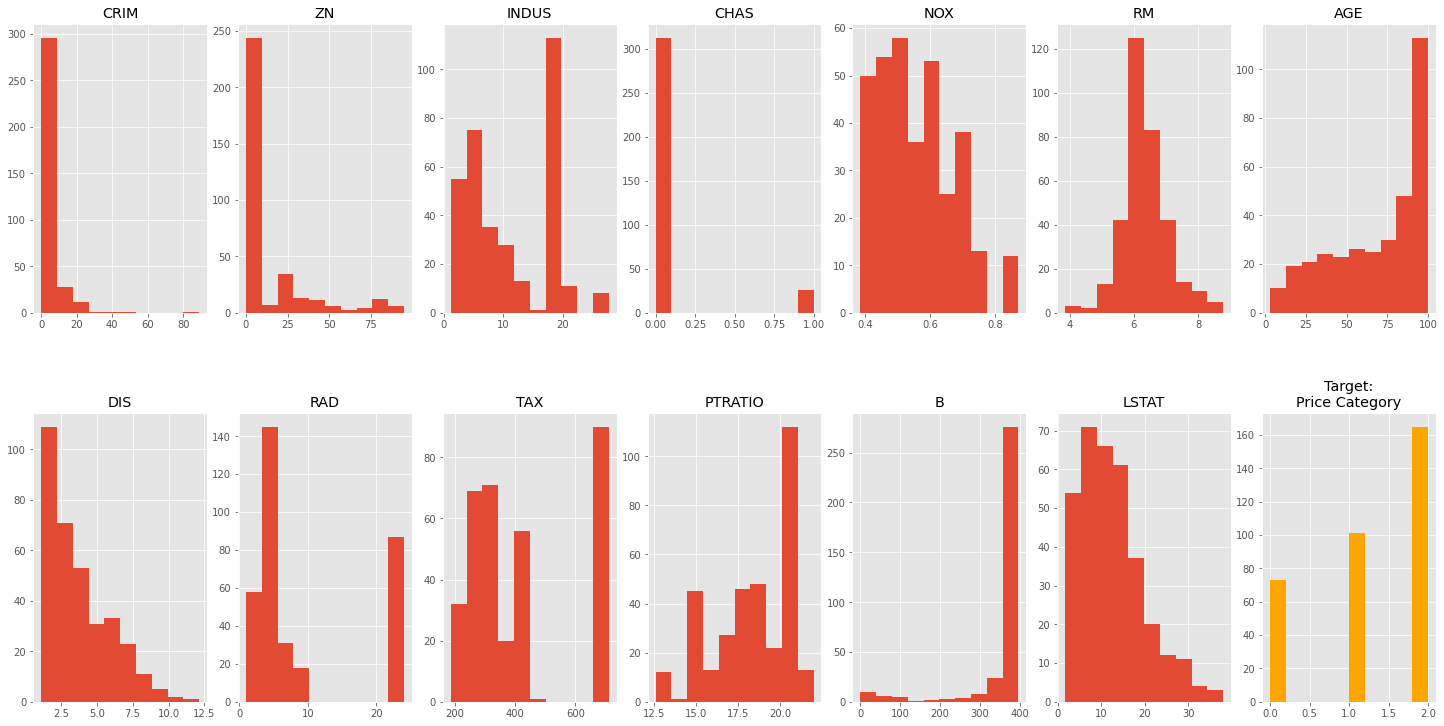

In [5]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10), sharey=False)
axs = axs.flatten()

x_train_arrys = x_train.values
for idx, feature in enumerate(x_train_arrys.T):
    axs[idx].hist(feature)
    axs[idx].set_title(f'{x_train.columns[idx]}')

axs[-1].hist(y_train, color='orange')
axs[-1].set_title(f'Target:\nPrice Category')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

## Kernel Density Estimation

Let's start by taking a closer look at the histogram of one of our features, the proportion of non-retail business acres per town.

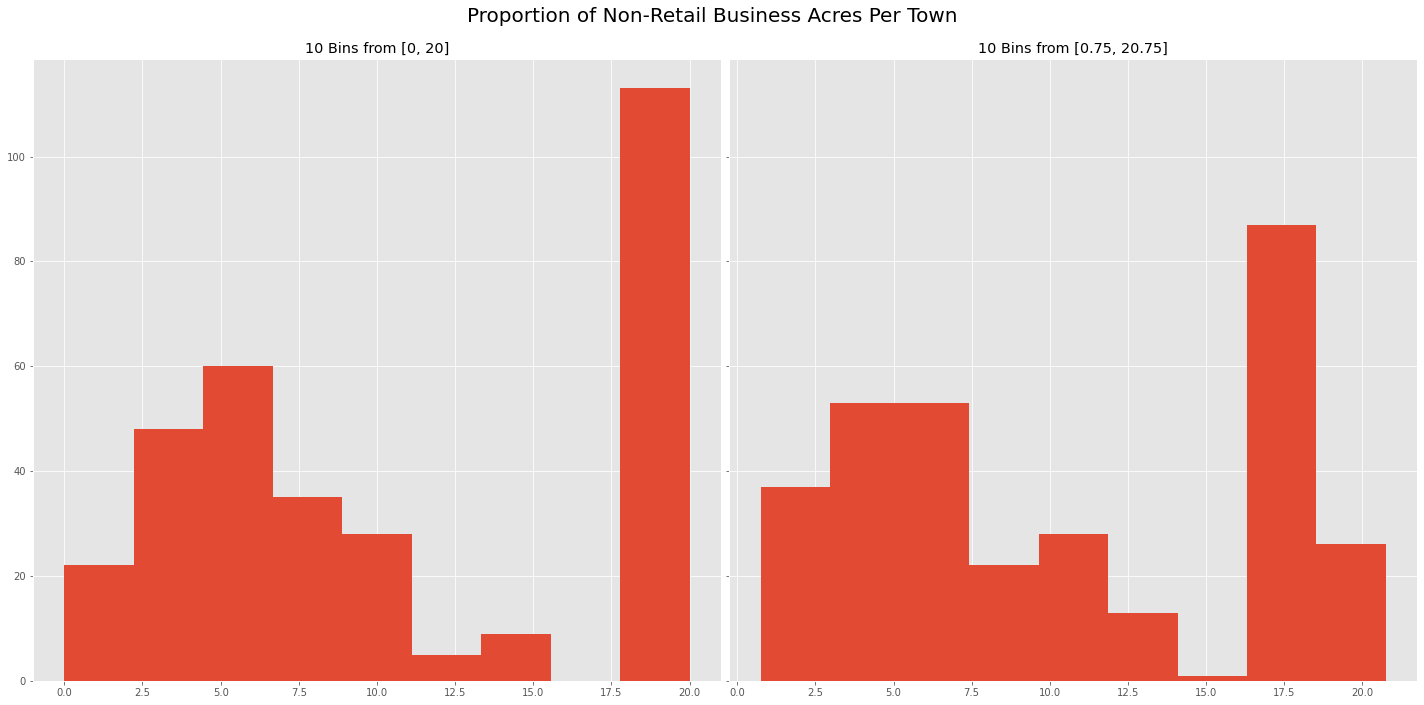

In [16]:
indus = x_train['INDUS'].values

fig, axs = plt.subplots(ncols=2, figsize=(20, 10), sharey=True)

num_bins = 10
bins = np.linspace(0, 20, num_bins)
axs[0].hist(indus, bins)
axs[1].hist(indus, bins + .75)

axs[0].set_title('10 Bins from [0, 20]')
axs[1].set_title('10 Bins from [0.75, 20.75]')

fig.suptitle('Proportion of Non-Retail Business Acres Per Town', fontsize=20)
plt.tight_layout(pad=1.5, w_pad=.5, h_pad=.5)

Let's fit a Kernel Density Estimator to try to model the distribution of the data.

In [17]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.75)

kde.fit(
    add_axis(indus)
)

KernelDensity(bandwidth=0.75)

In [18]:
X_plot = add_axis(
    np.linspace(0, 20, 1000)
)

log_density = kde.score_samples(X_plot)

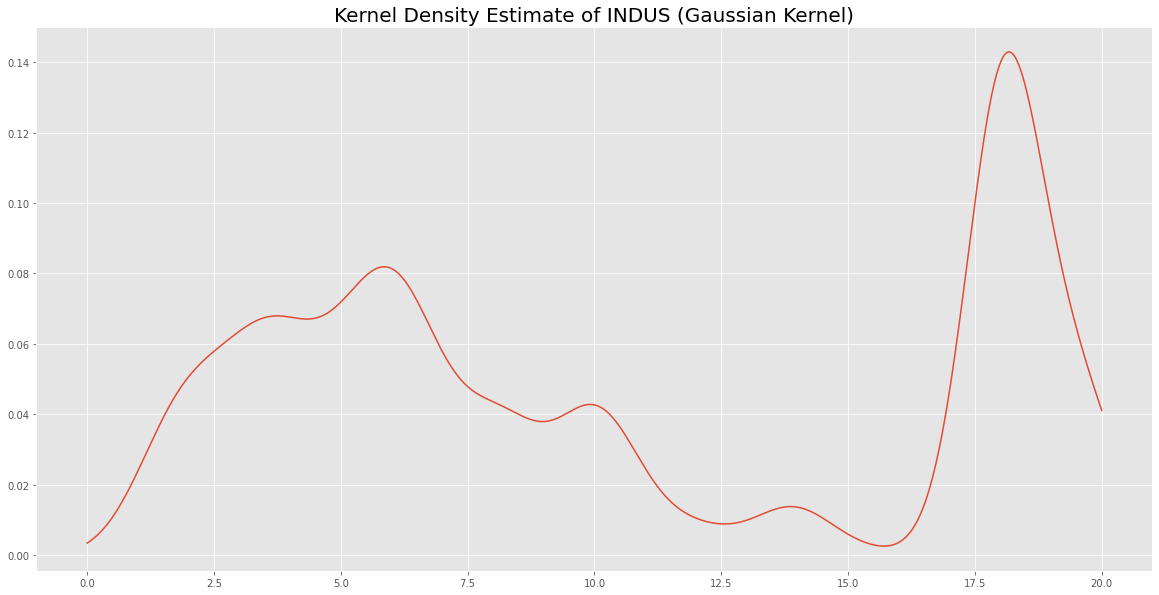

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(X_plot, np.exp(log_density))
_ = ax.set_title(
    'Kernel Density Estimate of INDUS (Gaussian Kernel)', 
    fontsize=20
)

## Visualizing K-Means on a Reduced Dimension of the Boston Classification Data

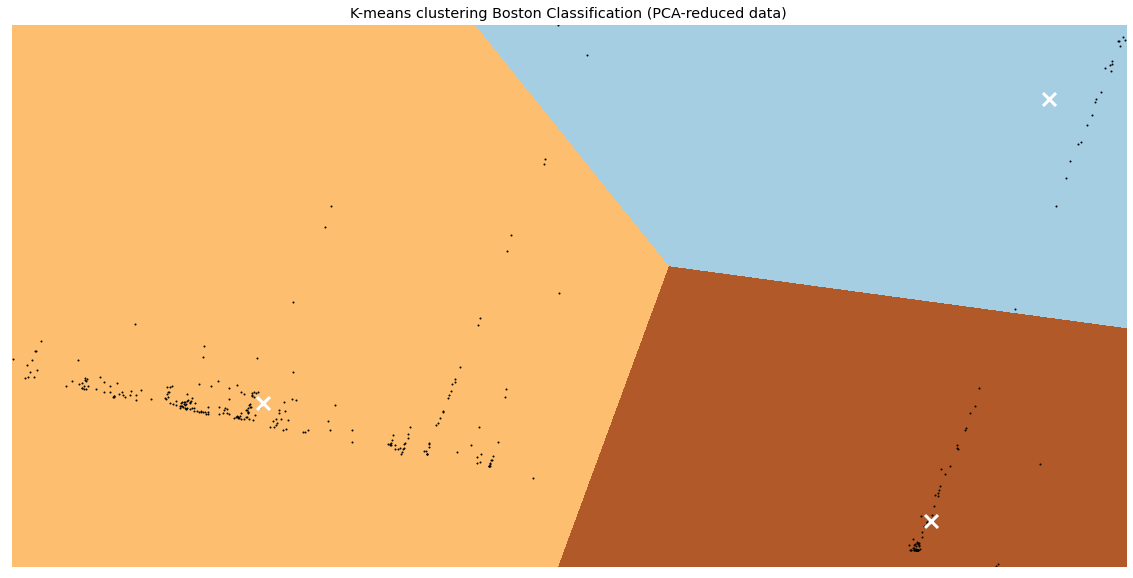

In [10]:
num_classes = len(np.unique(y_train))

# Use PCA to reduce the dimension of our data
reduced_data = PCA(n_components=2).fit_transform(x_train)

# Fit K-Means clustering with 3 clusters (hopefully aligning with our classes)
kmeans = KMeans(init='k-means++', n_clusters=num_classes, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02
# Plot the decision boundary, differentiating by color
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(20,10))
plt.clf()

plt.imshow(
    Z, 
    interpolation='nearest',
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect='auto', 
    origin='lower'
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
centroids = kmeans.cluster_centers_

plt.scatter(
    centroids[:, 0], 
    centroids[:, 1],
    marker='x', 
    s=169, 
    linewidths=3,
    color='w', 
    zorder=10
)

plt.title('K-means clustering Boston Classification (PCA-reduced data)')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()